# 546 (Optimization for Learning and Control) hw1

You are welcome (and encouraged) to work with others, but each individual must submit their own writeup.

You are welcome to use analytical and numerical computational tools; if you do, include the **commented** sourcecode in your writeup (e.g. the .ipynb file).

You are welcome to consult research articles and other materials; if you do, include a full citation in your writeup (e.g. the .ipynb file) and upload a .pdf of the article to Canvas alongside your homework submission.

## linear quadratic regulator

Consider the discrete-time linear quadratic regulator problem (DT-LQR)

$$\min_u c_\tau (x,u) \ \text{s.t.} \ x_{s+1} = A_s x_s + B_s u_s,$$
$$c_\tau(x,u) = \frac{1}{2} x_t^T P_t x_t + \frac{1}{2}\sum_{s=\tau}^{t-1} x_s^T Q_s x_s + u_s^T R_s u_s$$

where $P_t$, $\{Q_s\}_{s=\tau}^{t-1}$, $\{R_s\}_{s=\tau}^{t-1}$ are given symmetric positive-definite matrices.

In this problem, you'll apply Bellman's dynamic programming principle to determine the optimal control, then verify this control is the same one obtained by a descent algorithm.

a. Determine the optimal control and value at time $\tau = t$ (i.e. minimize $c_t$ with respect to $u_t$, and let $v^*_t = c_t(x^*,u^*)$ denote the optimal value that can be obtained at time $t$).

Since $c_t = \frac{1}{2} x_t^T P_t x_t$, any input is optimal; I'll choose $u_t^* = 0$.  The optimal value is $v_t^* = c_t = \frac{1}{2} x_t^T P_t x_t$.

b. Determine the optimal control and value at time $\tau = t-1$ (i.e. minimize $c_{t-1}$ with respect to $u_{t-1}$, and let $v^*_{t-1} = c_{t-1}(x^*,u^*)$ denote the optimal value that can be obtained at time $t-1$).

Substituting $x_t = A_{t-1} x_{t-1} + B_{t-1} u_{t-1}$ and differentiating $c_{t-1}$ with respect to $u_{t-1}$, we find
$$ D_{u_{t-1}} c_{t-1} = u_{t-1}^T R_{t-1} + (A_{t-1} x_{t-1} + B_{t-1} u_{t-1})^T P_t B_{t-1}. $$
Solving $D_{u_{t-1}} c_{t-1} = 0$ for $u_{t-1}$ yields
$$ u_{t-1}^* = -(B_{t-1}^T P_t B_{t-1} + R_{t-1})^{-1} B_{t-1}^T P_t A_{t-1} x_{t-1}. $$
(Note that $D_{u_{t-1}}^2 c_{t-1} = R_{t-1} + B_{t-1}^T P_t B_{t-1}$, which is a symmetric positive-definite matrix, so the input we computed is a strict local minimizer.)

We'll derive a simplified expression for the optimal value in the next step.

c. Note that the optimal control is linear in state and the optimal value is quadratic in state (i.e. determine $K_{t-1}$ and $P_{t-1}$ such that $u_{t-1} = K_{t-1} x_{t-1}$ and $v^*_{t-1} = c_{t-1}(x^*,u^*) = \frac{1}{2} x_{t-1}^T P_{t-1} x_{t-1}$).

Define $K_{t-1} = (B_{t-1}^T P_t B_{t-1} + R_{t-1})^{-1} B_{t-1}^T P_t A_{t-1}$ so that the optimal value at time $t-1$ is
$$ v_{t-1}^* = \frac{1}{2} x_{t-1}^T \left[ (A_{t-1} - B_{t-1} K_{t-1})^T P_t (A_{t-1} - B_{t-1} K_{t-1}) + K_{t-1}^T R_{t-1} K_{t-1} + Q_{t-1} \right] x_{t-1}; $$
use this expression to define $P_{t-1}$ such that $v_{t-1}^* = \frac{1}{2} x_{t-1}^T P_{t-1} x_{t-1}$.

d. Use the substitution in (c.) to generalize the calculation in (b.) to derive a recursive formula to compute the optimal control and value at any time $s\in [\tau,t]$.

It is straightforward to prove by induction that:
$$ K_s = (B_{s}^T P_{s+1} B_{s} + R_{s})^{-1} B_{s}^T P_{s+1} A_{s}, $$
$$ u_s^* = -K_s x_s, $$
$$ P_s = (A_{s} - B_{s} K_{s})^T P_{s+1} (A_{s} - B_{s} K_{s}) + K_{s}^T R_{s} K_{s} + Q_{s}, $$
$$ v_s^* = \frac{1}{2} x_s^T P_s x_s. $$
(Notes:  the recursion for $P_s$ is termed a *Riccati* difference equation; it is nonlinear, so not trivial to predict its asymptotic behavior as $s\rightarrow-\infty$.  It turns out that if $A$, $B$, $Q$, and $R$ are constant and $(A,B)$ is controllable, then the limit $\lim_{s\rightarrow-\infty} P_s = P$ is well-defined and $P$ satisfies the *discrete algebraic Riccati equation* $A^T P A - (A^T P B)(R + B^T P B)^{-1}(B^T P A) + Q$.)

e. Implement the recursion in (d.) numerically for the following system, which is a discretized linear spring-mass-damper (let $\kappa,\beta,q,r,\Delta > 0$ be parameters that you can easily vary in your implementation):

$$A^\Delta = I + \Delta \left[\begin{array}{cc} 0 & 1 \\ -\kappa & -\beta \end{array}\right],\ B^\Delta = \Delta \left[\begin{array}{c} 0 \\ 1 \end{array}\right],\ P_t = 0,\ Q^\Delta_s = q \cdot \Delta \cdot I,\ R^\Delta_s = r \cdot \Delta \cdot I.$$

In [105]:
import numpy as np
from scipy import linalg as la

def riccati(A,B,Q,R,P):
    # optimal control is linear state feedback 
    K_ = np.dot( la.inv(np.dot(B.T,np.dot(P,B)) + R), np.dot(B.T,np.dot(P,A)) )
    # optimal value is quadratic in state
    P_ = np.dot( (A - np.dot(B,K_)).T, np.dot(P, (A - np.dot(B,K_))) + np.dot(K_.T, np.dot(R, K_)) + Q )
    return K_,P_

n = 2
m = 1

def lqr(t,kappa=1,beta=1,q=1,r=1,Delta=1e-1):
    A = np.identity(n) + Delta * np.array([[0,1],[-kappa,-beta]])
    B = Delta * np.array([[0],[1]])
    Q = q * np.identity(n) # running state cost
    R = r * np.identity(m) # running control cost

    K = np.zeros((t,m,n)) # linear state feedback gain matrix
    P = np.zeros((t+1,n,n)) # cost-to-go

    Pt = np.zeros((n,n)) # final state cost
    P[t] = Pt

    # loop over times
    for s in range(t)[::-1]: # loop backward in time
        K[s],P[s] = riccati(A,B,Q,R,P[s+1])
        
    return A,B,Q,R,K,P

f. Verify your implementation in (e.) by performing gradient descent to approximate the optimal input on time horizon $t = 10$ and $t = 100$ for the following initial conditions with $\kappa,\beta,q,r = 1$, $\Delta = 0.1$:

$$x_1 = (1,0),\ x_2 = (0,1).$$

First, we'll compute the optimal control input using the Riccati equation derived above.

In [210]:
t = 10

u1 = np.zeros((t,m,1))
x1 = np.zeros((t+1,n,1))
x1[0] = [[1],[0]]
v1 = np.zeros((t))

u2 = np.zeros((t,m,1))
x2 = np.zeros((t+1,n,1))
x2[0] = [[0],[1]]
v2 = np.zeros((t))

A,B,Q,R,K,P = lqr(t)

for s in range(t):
    u1[s] = np.dot(-K[s],x1[s])
    x1[s+1] = np.dot(A,x1[s]) + np.dot(B, u1[s])
    v1[s] = 0.5 * np.dot( x1[s].T, np.dot(P[s], x1[s]) )
    u2[s] = np.dot(-K[s],x2[s])
    x2[s+1] = np.dot(A,x2[s]) + np.dot(B, u2[s])
    v1[s] = 0.5 * np.dot( x1[s].T, np.dot(P[s], x1[s]) )

Next, we'll approximate the optimal control input using steepest descent.

In [211]:
def c(w,x):
    t = w.size/m
    u = w.reshape((t,m,1))
    c = 0.
    
    for s in range(t):
        c += 0.5 * ( np.dot(x.T, np.dot(Q, x)) + np.dot(u[s].T, np.dot(R, u[s])) )
        x = np.dot(A,x) + np.dot(B,u[s])
        
    return c[0,0]

c1 = lambda w : c(w,x1[0])
c2 = lambda w : c(w,x2[0])

In [212]:
%run _546

w1 = u1.reshape((t*m))
for _ in range(8):
    w1 = steepest_descent(w1,c1)
u1_ = w1.reshape((t,m,1))

w2 = u2.reshape((t*m))
for _ in range(8):
    w2 = steepest_descent(w2,c2)
u2_ = w2.reshape((t,m,1))

Now we'll compare the two results.

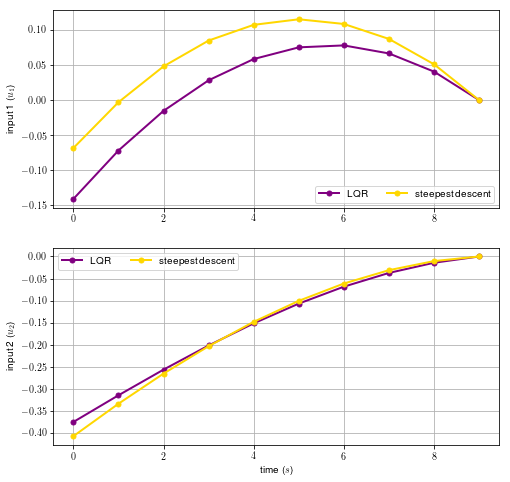

In [213]:
%matplotlib inline

lw = 2; ms = 10

fig = plt.figure(figsize=(8,8)); plt.clf()

plt.subplot(2,1,1); plt.grid('on')
plt.plot(u1[:,0,0],'.-',lw=lw,ms=ms,color='purple',label=r'LQR')
plt.plot(u1_[:,0,0],'.-',lw=lw,ms=ms,color='gold',label=r'steepest descent')
plt.ylabel(r'input 1 ($u_1$)')
plt.legend(loc='best',ncol=2)
plt.subplot(2,1,2); plt.grid('on')
plt.plot(u2[:,0,0],'.-',lw=lw,ms=ms,color='purple',label=r'LQR')
plt.plot(u2_[:,0,0],'.-',lw=lw,ms=ms,color='gold',label=r'steepest descent')
plt.ylabel(r'input 2 ($u_2$)')
plt.legend(loc='best',ncol=2)
plt.xlabel(r'time ($s$)');

Hmm -- one of them looks pretty similar, but one looks pretty different.

In principle, these are solutions of the same (strictly convex) optimization problem, so the solutions (i.e. the minimizers) should be equal . . .

Let's check the longer time horizon:

In [201]:
t = 100

u1 = np.zeros((t,m,1))
x1 = np.zeros((t+1,n,1))
x1[0] = [[1],[0]]
v1 = np.zeros((t))

u2 = np.zeros((t,m,1))
x2 = np.zeros((t+1,n,1))
x2[0] = [[0],[1]]
v2 = np.zeros((t))

A,B,Q,R,K,P = lqr(t)

for s in range(t):
    u1[s] = np.dot(-K[s],x1[s])
    x1[s+1] = np.dot(A,x1[s]) + np.dot(B, u1[s])
    v1[s] = 0.5 * np.dot( x1[s].T, np.dot(P[s], x1[s]) )
    u2[s] = np.dot(-K[s],x2[s])
    x2[s+1] = np.dot(A,x2[s]) + np.dot(B, u2[s])
    v1[s] = 0.5 * np.dot( x1[s].T, np.dot(P[s], x1[s]) )

In [204]:
w1 = u1.reshape((t*m))
for _ in range(8):
    w1 = steepest_descent(w1,c1)
u1_ = w1.reshape((t,m,1))

w2 = u2.reshape((t*m))
for _ in range(8):
    w2 = steepest_descent(w2,c2)
u2_ = w2.reshape((t,m,1))

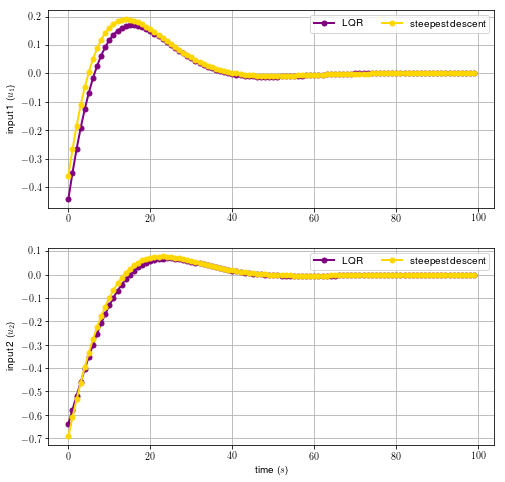

In [205]:
%matplotlib inline

lw = 2; ms = 10

fig = plt.figure(figsize=(8,8)); plt.clf()

plt.subplot(2,1,1); plt.grid('on')
plt.plot(u1[:,0,0],'.-',lw=lw,ms=ms,color='purple',label=r'LQR')
plt.plot(u1_[:,0,0],'.-',lw=lw,ms=ms,color='gold',label=r'steepest descent')
plt.ylabel(r'input 1 ($u_1$)')
plt.legend(loc='best',ncol=2)
plt.subplot(2,1,2); plt.grid('on')
plt.plot(u2[:,0,0],'.-',lw=lw,ms=ms,color='purple',label=r'LQR')
plt.plot(u2_[:,0,0],'.-',lw=lw,ms=ms,color='gold',label=r'steepest descent')
plt.ylabel(r'input 2 ($u_2$)')
plt.legend(loc='best',ncol=2)
plt.xlabel(r'time ($s$)');

Steepest descent seemed to fare better on the longer time horizon; this isn't an entirely satisfying result.

Perhaps we're seeing differences because we were lazy and used a finite-difference approximation for the gradient (conveniently computed automatically for us by the *steepest_descent()* function) -- let's compute the gradient using the costate equation derived for general nonlinear optimal control problems:

$$\lambda_{s-1} = D_x L_s (x_s, u_s) + \lambda_s \cdot D_x F_s (x_s, u_s),\ \lambda_t = D_x \ell_t (x_t).$$

Here, $D_x L_s (x_s, u_s) = x_s^T Q$, $D_x \ell_t (x_t) = 0$, and $D_x F_s (x_s, u_s) = A$, so this is a linear time-invariant DE with time-varying input ($x_s^T Q$).  Once the $\lambda$'s have been computed, the derivative of the cost $c$ with respect to the input at time $s$, $u_s$, can be easily computed as:

$$D_{u_s} L_s (x_s, u_s) = - \lambda_s \cdot D_u F_s (x_s, u_s).$$

Here, $D_u F_s (x_s, u_s) = B$, so $D_{u_s} L_s (x_s, u_s) = - \lambda_s \cdot B$.

In [215]:
def Dc(w,x0):
    t = w.size/m
    u = w.reshape((t,m,1))
    x = np.zeros((t+1,n,1))
    x[0] = x0
    
    for s in range(t):
        x[s+1] = np.dot(A,x[s]) + np.dot(B,u[s])
        
    Dc = np.zeros((t,1,m))
        
    l = np.nan*np.zeros((t+1,1,n))
    l[-1] = np.dot(x[-1].T,P[-1])
    for s in range(1,t+1)[::-1]:
        l[s-1] = (np.dot(l[s], A) + np.dot(x[s].T, Q))
        Dc[s-1] = -np.dot(l[s-1],B)
    
    return Dc.reshape((t*m))

Dc1 = lambda w : Dc(w,x1[0])
Dc2 = lambda w : Dc(w,x2[0])

Unfortunately, this seems to be giving the wrong answer.  I'm not sure if the math is wrong, the code is wrong, or both.

**Extra credit:** find the error(s) above so that the derivative computed using the co-state $\lambda$ agrees with the finite-differences calculation.

In [217]:
w = np.random.randn(t*m)

np.set_printoptions(precision=3)
print D(c1,w)
print Dc1(w)
#print D(c1,w1) - Dc1(w1)

g. Investigate how the optimal controls vary with respect to the ratio $q/r$ (i.e. let $q/r$ range from $0.1$ to $10$, compute the optimal control input, describe the trend you observe, and provide a visualization that clearly illustrates this trend).

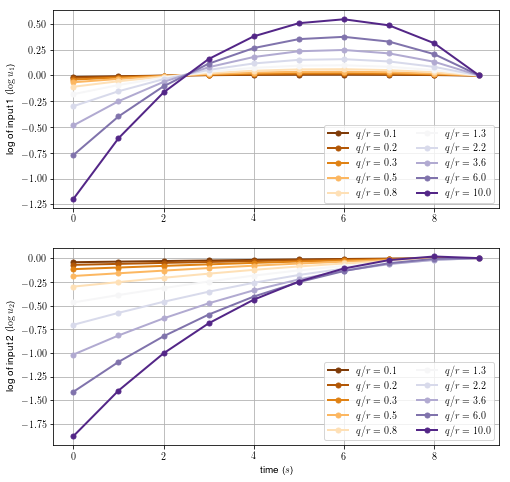

In [29]:
from matplotlib import cm

t = 10

u1 = np.zeros((t,m,1))
x1 = np.zeros((t+1,n,1))
x1[0] = [[1],[0]]
v1 = np.zeros((t))

u2 = np.zeros((t,m,1))
x2 = np.zeros((t+1,n,1))
x2[0] = [[0],[1]]
v2 = np.zeros((t))

import pylab as plt
fig = plt.figure(figsize=(8,8)); plt.clf()

num = 10

for c,q in enumerate(np.logspace(-1,1,num=num)):
    A,B,Q,R,K,P = lqr(t,q=q,r=1.)

    for s in range(t):
        u1[s] = np.dot(-K[s],x1[s])
        x1[s+1] = np.dot(A,x1[s]) + np.dot(B, u1[s])
        v1[s] = 0.5 * np.dot( x1[s].T, np.dot(P[s], x1[s]) )
        u2[s] = np.dot(-K[s],x2[s])
        x2[s+1] = np.dot(A,x2[s]) + np.dot(B, u2[s])
        v1[s] = 0.5 * np.dot( x1[s].T, np.dot(P[s], x1[s]) )
    
    plt.subplot(2,1,1); plt.grid('on')
    plt.plot(u1[:,0,0],'.-',lw=lw,ms=ms,color=cm.PuOr(1.*c/num),label=r'$q/r =%0.1f$'%q)
    plt.ylabel(r'input 1 ($u_1$)')
    plt.legend(loc='best',ncol=2)
    plt.subplot(2,1,2); plt.grid('on')
    plt.plot(u2[:,0,0],'.-',lw=lw,ms=ms,color=cm.PuOr(1.*c/num),label=r'$q/r =%0.1f$'%q)
    plt.ylabel(r'input 2 ($u_2$)')
    plt.legend(loc='best',ncol=2)
    plt.xlabel(r'time ($s$)')

We observe that, when state error is much more costly than input effort ($q/r \approx 10$), large inputs are applied that decrease state error rapidly.  Correspondingly, when state error is much less costly than input effort ($q/r \approx 0.1$), small inputs are applied that decrease state error slowly.

h. Compare the results from (e.)/(f.) with the results obtained from the solution to the continuous-time linear quadratic regulator (CT-LQR):

$$A = \frac{1}{\Delta} (A^\Delta - I),\ B = \frac{1}{\Delta} B^\Delta,\ Q = \frac{1}{\Delta} Q^\Delta,\ R = \frac{1}{\Delta} R^\Delta,$$

$$u^*_s = - K_s x_s,\ K_s = R^{-1} B^T P_s,$$

$$v^*_s = \frac{1}{2} x_s^T P_s x_s,\ \dot{P_s} = -(A^T P_s + P_s A - P_s B R^{-1} B^T P_s + Q).$$

Investigate how the comparison varies with respect to $\Delta$ (i.e. let $\Delta$ range from $\sim 10^0$ to $\sim 10^{-8}$ and plot the norm of the difference between the optimal inputs and values as a function of $\Delta$). 

In [252]:
DTlqr = lqr
DTriccati = riccati

def CTriccati(A,B,Q,R,P):
    # optimal control is linear state feedback 
    K_ = np.dot( la.inv(R), np.dot(B.T,A) )
    # optimal value is quadratic in state
    P_ = ( np.dot(A.T, P) + np.dot(P, A) + Q
           - np.dot(P, np.dot(B, np.dot(la.inv(R), np.dot(B.T, P)))) )
    return K_,P_

def CTlqr(t,kappa=1,beta=1,q=1,r=1,Delta=1e-1):
    A = np.array([[0,1],[-kappa,-beta]])
    B = np.array([[0],[1]])
    Q = q * np.identity(n) / Delta # running state cost
    R = r * np.identity(m) / Delta # running control cost

    K = np.zeros((t,m,n)) # linear state feedback gain matrix
    P = np.zeros((t+1,n,n)) # cost-to-go

    Pt = np.zeros((n,n)) # final state cost
    P[t] = Pt

    # loop over times
    for s in range(t)[::-1]: # loop backward in time
        K[s],dP = CTriccati(A,B,Q,R,P[s+1])
        P[s] = P[s+1] + Delta * dP
        
    return A,B,Q,R,K,P

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:57: RuntimeWarning: overflow encountered in square


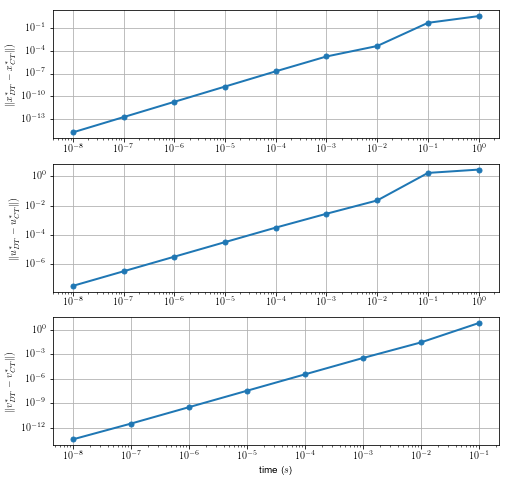

In [255]:
fig = plt.figure(figsize=(8,8)); plt.clf()

num = 9

Deltas = np.logspace(-8,0,num=num)

t = 10

u1 = np.zeros((t,m,1))
x1 = np.zeros((t+1,n,1))
x1[0] = [[1],[0]]
v1 = np.zeros((t))

u2 = np.zeros((t,m,1))
x2 = np.zeros((t+1,n,1))
x2[0] = [[0],[1]]
v2 = np.zeros((t))

dx = np.zeros((num,t+1,n,1))
du = np.zeros((num,t,m,1))
dv = np.zeros((num,t))

for N,Delta in enumerate(Deltas):
    A,B,Q,R,K,P = DTlqr(t,q=q,r=1.,Delta=Delta)
    for s in range(t):
        u1[s] = np.dot(-K[s],x1[s])
        x1[s+1] = np.dot(A,x1[s]) + np.dot(B, u1[s])
        v1[s] = 0.5 * np.dot( x1[s].T, np.dot(P[s], x1[s]) )
        u2[s] = np.dot(-K[s],x2[s])
        x2[s+1] = np.dot(A,x2[s]) + np.dot(B, u2[s])
        v1[s] = 0.5 * np.dot( x1[s].T, np.dot(P[s], x1[s]) )
    
    dx[N] = x1    
    du[N] = u1
    dv[N] = v1
    
    A,B,Q,R,K,P = CTlqr(t,q=q,r=1.,Delta=Delta)
    for s in range(t):
        u1[s] = np.dot(-K[s],x1[s])
        x1[s+1] = x1[s] + Delta * (np.dot(A,x1[s]) + np.dot(B, u1[s]))
        v1[s] = 0.5 * np.dot( x1[s].T, np.dot(P[s], x1[s]) )
        u2[s] = np.dot(-K[s],x2[s])
        x2[s+1] = x1[s] + Delta * (np.dot(A,x2[s]) + np.dot(B, u2[s]))
        v1[s] = 0.5 * np.dot( x1[s].T, np.dot(P[s], x1[s]) )
        
    dx[N] -= x1
    du[N] -= u1
    dv[N] -= v1
    
plt.subplot(3,1,1); plt.grid('on')
plt.loglog(Deltas,np.sqrt(np.sum(dx**2,axis=(1,2,3))),'.-',lw=lw,ms=ms)
plt.ylabel(r'$\|x_{DT}^* - x_{CT}^*\|)$')
plt.subplot(3,1,2); plt.grid('on')
plt.loglog(Deltas,np.sqrt(np.sum(du**2,axis=(1,2,3))),'.-',lw=lw,ms=ms)
plt.ylabel(r'$\|u_{DT}^* - u_{CT}^*\|)$')
plt.subplot(3,1,3); plt.grid('on')
plt.loglog(Deltas,np.sqrt(np.sum(dv**2,axis=1)),'.-',lw=lw,ms=ms)
plt.ylabel(r'$\|v_{DT}^* - v_{CT}^*\|)$')
plt.xlabel(r'time ($s$)');

This is very satisfying -- other than $\Delta\approx 10^0$ yielding optimal values that overflow our floating point numbers, we see an asymptotically linear decrease in approximation error between the discrete- and continuous-time LQR.

(Confirming the largest $\Delta$ yields optimal values that are too large for our floating point arithmetic:)

In [256]:
dv[-1]

array([         nan,   3.676e+251,   5.246e+123,   6.267e+059,
         6.849e+027,   7.161e+011,   7.300e+003,  -1.499e+001,
        -1.014e+001,  -4.996e+000])

Yep -- *NaN* (Not a Number) is too large :)

**BONUS** show that the solution to (CT-LQR) can be obtained by taking the limit of the (DT-LQR) recursion from (d.)/(e.) as $\Delta \rightarrow 0$.

## application

a. Specify an optimal control problem for a system of your choosing (e.g. a system from the paper you plan to present or the project you plan to complete for the class).  Be precise:  provide the mathematical definitions for all symbols.  Also, be clear:  provide plain language explanations for what each symbol corresponds to in the application.

b. Discuss what methods have been applied in the literature to solve or approximate solutions to the optimal control problem from (a.), and what (if anything) is known about the solution.

c. Attempt to apply a technique for optimal control to the problem from (a.).  You can try one of the methods discussed in class (e.g. directly apply the dynamic programming principle, or apply a numerical descent algorithm), one of the methods discussed in (b.), or another method of your choosing.  